# Language Identification

**Outline:**
1. Read raw data
2. Clean data
3. Try existing language identification libraries
4. Construct our own dictionary-based language classifier
5. Construct our own language classifier using supervised learning

**What you need to do:** 
- Read and execute the source code below and answer the questions in **EXERCISE 1 - EXERCISE 6**. 
- **Submit** the modifiled file ``TD2.ipynb`` on google drive.

In [37]:
import pandas as pd
import numpy as np

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline

# set the font size of plots
plt.rcParams['font.size'] = 14

In [39]:
np.set_printoptions(precision=3)

## Read raw data

In [40]:
corpus_files = ['./langid_data_TUN-AR.txt', './langid_data_ARA.txt']

In [41]:
def read_text_file(filename):
    print('Reading file ' + filename + "...")
    with open(filename, "r", encoding='utf8') as textfile:
        L = []
        for line in textfile:
            L.append(line.strip())
        print('File contains ', len(L), "lines.\n")
        return L

In [42]:
tun_corpus = read_text_file(corpus_files[0])
ara_corpus = read_text_file(corpus_files[1])

Reading file ./langid_data_TUN-AR.txt...
File contains  13932 lines.

Reading file ./langid_data_ARA.txt...
File contains  21787 lines.



## Text Cleaning
For language identification, we usually only need to remove non-word characters and replace them with spaces. But since our corpus contains social media text, a few other operations are necessary.

- Remove non-word symbols (punctuation, math symbols, emoticons, URLs, hashtags, etc.).
- Replace punctuation and white space with a single space.
- Normalize word elongations and word repetitions.
- Remove documents that contain a large fraction of latin characters (some documents contain english or french words).
- Remove very short documents.

In [43]:
import re

# regexp for word elongation: matches 3 or more repetitions of a word character.
two_plus_letters_RE = re.compile(r"(\w)\1{1,}", re.DOTALL)
three_plus_letters_RE = re.compile(r"(\w)\1{2,}", re.DOTALL)
# regexp for repeated words
two_plus_words_RE = re.compile(r"(\w+\s+)\1{1,}", re.DOTALL)


def cleanup_text(text):
    # Remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)

    # Remove user mentions of the form @username
    text = re.sub('@[^\s]+', '', text)
    
    # Replace special html-encoded characters with their ASCII equivalent, for example: &#39 ==> '
    #if re.search("&#",text):
        #text = html.unescape(text)

    # Remove special useless characters such as _x000D_
    text = re.sub(r'_[xX]000[dD]_', '', text)

    # Replace all non-word characters (such as emoticons, punctuation, end of line characters, etc.) with a space
    text = re.sub('[\W_]', ' ', text)

    # Remove redundant white spaces
    text = text.strip()
    text = re.sub('[\s]+', ' ', text)

    # normalize word elongations (characters repeated more than twice)
    text = two_plus_letters_RE.sub(r"\1\1", text)

    # remove repeated words
    text = two_plus_words_RE.sub(r"\1", text)

    return text

# unit test of this function
cleanup_text("This is just a simple. js .... jshd)jhsd__js--dh \n\n asjh\n test !!")

'This just a simple js jshd jhsd js dh asjh test'

### EXERCISE 1

Do the following operations for **each** corpus. Store the new corpora in new variables called ``tun_corpus_clean`` and ``ara_corpus_clean``
1. Clean up each document in the corpus using the ``cleanup_text`` function given above.
2. Remove all documents that contain a large fraction of latin characters (for example more than 70%).  **Hint**: use a regular expression with pattern [a-zA-Z]
3. Remove very short documents (containing less than 10 characters, for e.g.).
4. Display the number of documents in the clean corpus.

In [44]:
## COMPLETE THE CODE BELOW
#1
tun_corpus_clean = [cleanup_text(doc) for doc in tun_corpus]
ara_corpus_clean = [cleanup_text(doc) for doc in ara_corpus]

print(len(tun_corpus_clean), len(ara_corpus_clean))

13932 21787


In [45]:
#2
#tun_corpus_clean=[re.sub('[a-zA-Z]+','',doc) for doc in tun_corpus_clean]
tun_corpus_clean2=[doc for doc in tun_corpus_clean if (len(re.findall('[a-zA-Z]+',doc))/len(doc))<0.7]

In [46]:
#2
#ara_corpus_clean=[re.sub(' [a-zA-Z]+','',doc) for doc in ara_corpus_clean]
ara_corpus_clean2=[doc for doc in ara_corpus_clean if (len(re.findall('[a-zA-Z]+',doc))/len(doc))<0.7]

In [47]:
#3
tun_corpus_clean3 = [cleanup_text(doc) for doc in tun_corpus_clean2 if len(doc)>10]
ara_corpus_clean3 = [cleanup_text(doc) for doc in ara_corpus_clean2 if len(doc)>10]
print(len(tun_corpus_clean3), len(ara_corpus_clean3))

12039 21459


## Try existing language identification libraries
- In TD1, we used NLTK's textcat library.
- In this TD, we will use another 2 libraries (``langdetect`` and ``langid``) which are actually more accurate than ``textcat``. However, as you will see they 

### Load special libraries for language identification

In [48]:
test_doc = "This is just a simple test !!"

In [49]:
# langdetect library

import langdetect
from langdetect.lang_detect_exception import LangDetectException

try:
    res = langdetect.detect_langs(test_doc)   # LANGDETECT
    #res = langdetect.detect(test_doc) 
except LangDetectException:
    res = langdetect.language.Language("UNK",0)
res

[en:0.9999979865821665]

In [50]:
# langid library

from langid.langid import LanguageIdentifier, model
li = LanguageIdentifier.from_modelstring(model, norm_probs=True)
print(li.classify(test_doc))
print(li.rank(test_doc)[0:3])

('en', 0.9999998819046767)
[('en', 0.9999998819046767), ('br', 1.1536448337940777e-07), ('la', 1.4557736338637932e-09)]


In [51]:
# NLTK textcat library - JUST IN CASE
from nltk.classify.textcat import TextCat

# create class instance
tc = TextCat()
tc.guess_language(test_doc)

'eng'

### Test ``langdetect`` on a small sample of Tunisian Corpus

In [52]:
# Select a small random sample of 5000 documents from the corpus
n = 5000
random_indices = np.random.choice(np.arange(len(tun_corpus_clean3)), n, replace=False)
small_corpus = [tun_corpus_clean[i] for i in random_indices]

In [53]:
res_langdetect = []

for doc in small_corpus:
    try:
        res_langdetect.append(langdetect.detect_langs(doc))
    except LangDetectException:
        res_langdetect.append([langdetect.language.Language("UNK",0)])

In [54]:
len(small_corpus),len(res_langdetect)

(5000, 5000)

### Visualize results

In [55]:
# Let's put the results in a data frame for ease of manipulation

def foo1(x):
    u = str(x).split(':')
    return [u[0],float(u[1])]
L = [[small_corpus[i]]+foo1(x[0]) for i,x in enumerate(res_langdetect)]
df = pd.DataFrame(L)
df.columns = ['document', 'language','probability']
df.head()

,document,language,probability
0,مله مناظرامقلبه جابتهم هاثوره الكلبه تفوه,ar,0.999997
1,وحدك لطفي,ar,0.999999
2,موزاييك اذاعة الفواحش اصلا هه,ar,0.999999
3,شكونك انتي كنقارنوك باخيب امرة اكرانية من ناحي...,ar,0.999998
4,خير من نوفل,ar,0.999997


### EXERCISE 3
1. Plot the distribution of languages (call value_counts() on the ``language`` column of ``df``)
2. Plot the histogram of probabilities (call plot(kind='hist') on the ``probability`` column of ``df``)
3. What are the top 2 languages identified in this corpus?
4. For what fraction of documents is this language identifier more than 80% confident in its decision? (i.e. probability > 0.8)

ENTER YOUR ANSWERS BELOW

...

...


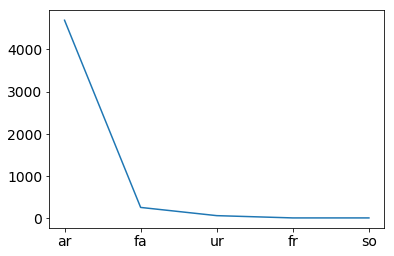

In [56]:
## ENTER YOUR SOURCE CODE BELOW

#1
plt.plot(df.language.value_counts())



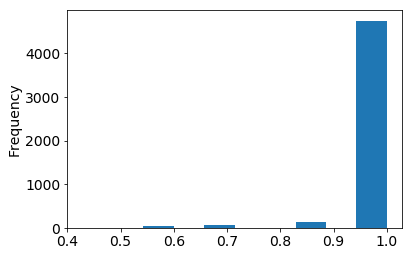

In [57]:
#2
df.probability.plot(kind='hist')
#3
# the top 2 languages identified in this corpus are Arabe and farsi

In [58]:
#4
fraction=len([a for a in df.probability if a >0.8]) / len(df.probability)
fraction

0.9746

### EXERCISE 4 (homework - skip this during class)

1. Test both libraries (``langdetect`` and ``langid``) on the **entire** ``ara_corpus_clean`` corpus.
2. Which library seems to be more accurate for the Arabic language? Justify based on visual inspection of the results.
3. Design a new language identification method that combines both libraries -- basically just use the result corresponding to the higher probability.
4. Is this new method more accurate than the individual methods? Again, justify your answer based on visual inspection of the results.

Responses:
1.

In [59]:
# Select a small random sample of 5000 documents from the corpus
n = 5000
random_indices = np.random.choice(np.arange(len(ara_corpus_clean3)), n, replace=False)
small_corpus_ara = [ara_corpus_clean[i] for i in random_indices]

#langid
res_langid_ara = []
for doc in small_corpus_ara:
    res_langid_ara.append(li.classify(doc))
    
#langdetect
res_langdetect_ara = []

for doc in small_corpus_ara:
    try:
        res_langdetect_ara.append(langdetect.detect_langs(doc))
    except LangDetectException:
        res_langdetect_ara.append([langdetect.language.Language("UNK",0)])


******

2. According to the following results,Langdetect seems to be more accurate for the Arabic language because it has the highest mean. (0.99>0.98)

In [60]:
L=[foo1(x[0]) for i,x in enumerate(res_langdetect_ara)]
df = pd.DataFrame(L)
df.columns = ['language','probability']
df.head()
df.describe()

,probability
count,5000.000000
mean,0.996687
std,0.033840
min,0.000000
25%,0.999997
50%,0.999998
75%,0.999999
max,1.000000


In [61]:
dfid = pd.DataFrame(res_langid_ara)
dfid.columns = ['language', 'probability']
dfid.head()
dfid.describe()

,probability
count,5000.000000
mean,0.989119
std,0.063323
min,0.169462
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


3. The new language identification method that combines both libraries is : 

In [63]:
combine=[]
for i in range(0, len(res_langdetect_ara)):
    if(df.probability[i]>dfid.probability[i]):
        combine.append(df.iloc[i].tolist())
    
    else:
        combine.append(dfid.iloc[i].tolist())
combine

[['ar', 0.9999982480653715],
 ['ar', 1.0],
 ['ar', 0.9999999999997533],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 0.9999964200235134],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 0.9999999998681559],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 0.9999999991986095],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 0.9999999999992943],
 ['ar', 1.0],
 ['ar', 0.9999998291804134],
 ['ar', 1.0],
 ['ar', 0.9999989153293266],
 ['ar', 1.0],
 ['ar', 0.9999991988257696],
 ['ar', 1.0],
 ['ar', 0.9999999916325598],
 ['ar', 1.0],
 ['ar', 0.9999999999999996],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 0.9999999999999996],
 ['ar', 0.9999970581110003],
 ['ar', 1.0],
 ['ar', 0.9999999999999929],
 ['ar', 0.9999999999999765],
 ['ar', 1.0],
 ['ar', 1.0],
 ['ar', 0.9999999893449384],
 ['ar', 1.0],
 ['ar', 0.9999976673048858],
 ['ar', 1.0],
 ['ar', 0.9999999999999989],
 ['ar', 1.0],
 ['ar', 1.0],
 [

In [64]:
combine_df = pd.DataFrame(combine)
combine_df.columns = ['language','probability']
combine_df.describe()

,probability
count,5000.000000
mean,0.998548
std,0.020655
min,0.428571
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


4. Yes, this new method is more accurate than the individual methods because it has the highest mean (0.998>0.996>0.98)

## Construct a dictionary-based language classifier
- **Step 1**: Divide each corpus into a training corpus (70%) and test corpus (30%).
- **Step 2**: learn a set of typical words (also called stop words) of **every language** (TUN and ARA) based on its training corpus.
- **Step 3**: create a language identification algorithm that takes the list of typical words of each language and a new document as input; and returns the language of this document as output.
- **Step 4**: Evaluate the performance of this algorithm based on the test corpus -- calculate classification accuracy, precision, recall, F1, and confusion matrix.

### EXERCISE 5
Implement each step by following the instructions in the comments below.

In [65]:
# Step 1   COMPLETE THE CODE BELOW

from sklearn.model_selection import train_test_split
#?train_test_split

tun_corpus_clean_train, tun_corpus_clean_test = train_test_split(tun_corpus_clean3, test_size=0.3 )

ara_corpus_clean_train, ara_corpus_clean_test = train_test_split(ara_corpus_clean3, test_size=0.3 )


In [66]:
# Step 2   Follow the instructions below

from sklearn.feature_extraction.text import TfidfVectorizer
P = 1000   ## configuration hyperparameter; you can modify it if you want; see instructions below.

## COMPLETE THE CODE BELOW


## Find typical words of the TUN language

# create TfidfVectorizer instance with maxdf = 1.0 so that the most frequent words of the corpus are NOT thrown away
bow_model_tun = TfidfVectorizer (max_df = 1.0, min_df = 0.005)

# call fit() method with our TUN corpus; this will create the vocabulary of the corpus ...
bow_model_tun.fit( tun_corpus_clean_train )

# select P words from this vocabulary that have the SMALLEST IDF values -- See the source code in TD1 for help ...
tun_vocab=bow_model_tun.get_feature_names ()
u=pd.DataFrame(dict(Word=tun_vocab,IDF=bow_model_tun.idf_)).sort_values("IDF", inplace=False, ascending = True)

# Note: we do not need to create the DTM matrix in this part.

typical_words_tun = u.Word[0:P]

u.head()


,Word,IDF
150,في,2.503484
202,من,2.896487
236,يا,2.991798
132,علي,3.093301
31,الله,3.285877


In [67]:
bow_model_ara = TfidfVectorizer (max_df = 1.0, min_df = 0.005)

# call fit() method with our TUN corpus; this will create the vocabulary of the corpus ...
bow_model_ara.fit( ara_corpus_clean_train )

# select P words from this vocabulary that have the SMALLEST IDF values -- See the source code in TD1 for help ...
ara_vocab=bow_model_ara.get_feature_names ()
v=pd.DataFrame(dict(Word=ara_vocab,IDF=bow_model_ara.idf_)).sort_values("IDF", inplace=False, ascending = True)

# Note: we do not need to create the DTM matrix in this part.

typical_words_ara = v.Word[0:P]

v.head()

,Word,IDF
1262,من,1.476066
999,في,1.636344
940,على,1.973269
692,جدا,2.046537
388,الفندق,2.130331


In [68]:
# Step 3 -- write the algorithm for dictionary-based language identification. 
#    This algorithm selects the language that has the highest number of typical words in the input document.

## COMPLETE THE CODE BELOW
def dict_langid(typical_words,doc):
    sum=0
    for i in typical_words:
         if i in doc:
                sum=sum+1
    lang=float(sum/len(doc))
    return lang

# for each document in the test combined test corpus, call dict_langid with typical_words_tun and then with typical_words_tun
# dict_langid(typical_words_tun, doc)
# dict_langid(typical_words_ara, doc)
# ...
sumARA=0
sumTUN=0
for doc in tun_corpus_clean_test:
    if (dict_langid(typical_words_ara,doc) > dict_langid(typical_words_tun,doc)):
        sumARA = sumARA+1
    else:
        sumTUN = sumTUN+1
if(sumARA >= sumTUN):
    Lang='ARA'
else:
    Lang='TUN'
print(Lang)   

TUN


In [69]:
sumARA=0
sumTUN=0
for doc in ara_corpus_clean_test:
    if (dict_langid(typical_words_ara,doc) > dict_langid(typical_words_tun,doc)):
        sumARA = sumARA+1
    else:
        sumTUN = sumTUN+1
if(sumARA >= sumTUN):
    Lang='ARA'
else:
    Lang='TUN'
print(Lang)   

ARA


In [70]:
# Step 4
# Reference: see scikit-learn documentation

## COMPLETE THE CODE BELOW

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score



******

## Construct a language classifier using supervised learning
- **Step 0**: Divide each corpus into a training corpus (70%) and test corpus (30%).
- **Step 1**: Create a data frame called ``train_df`` that has two columns: 'document' and 'language'. The 'document' column contains the two corpora concatenated together. The values in the '' column should be 'TUN' and 'ARA'.  Repeat the same thing for the ``test_df``.
- **Step 2**: Convert the training documents into numeric feature vectors using the BOW-tfidf method with **character ngrams**.
- **Step 3**: Create a language classifier using Naive Bayes method (tfidf version).
- **Step 4**: Evaluate performance of this classifier based on the test corpus -- calculate classification accuracy, precision, recall, F1, and confusion matrix.

### EXERCISE 6
Implement each step by carefully following the instructions above.

In [71]:
# Step 0 just use the same variables that you created in Step 1 of the previous part.
# Nothing to do

In [72]:
# Step 1   create 2 data frames called train_df and test_df (as explained above)

## COMPLETE THE CODE BELOW

# create data frame
train_df = pd.DataFrame({'document':[], 'language':[]})

# fill the language column
train_df.language = pd.Series(['TUN']*len(tun_corpus_clean_train) + ['ARA']*len(tun_corpus_clean_train))


# fill the document column -- CONCATENATE the TUN CORPUS and ARA CORPUS
train_df.document = pd.Series(tun_corpus_clean_train + ara_corpus_clean_train)


train_df.head()

,document,language
0,بربي لا عاد تجيبولنا الوجوه هذي الشعب يولي يجر...,TUN
1,كانت قصة جد مءثرة تحياتنا من الجزاءر,TUN
2,التافه كريم الغربي,TUN
3,انا فديت من تفاهتكم و فسادكم و بيع دينكم و بلد...,TUN
4,سيد الرءيس ربي يكون معاك وربي يعينك علي كل متر...,TUN


In [76]:
test_df = pd.DataFrame({'document':[], 'language':[]})
test_df.language = pd.Series(['TUN']*len(tun_corpus_clean_test) + ['ARA']*len(tun_corpus_clean_test))
test_df.document = pd.Series(tun_corpus_clean_test + ara_corpus_clean_test)
test_df.head()

,document,language
0,الفة بن رمصان فنانة و نصف ابدعت,TUN
1,كوميدي رقم واحد في تونس و الشيء من ماتاه لا يس...,TUN
2,blablabla باين فيها سهرة مارقة نشوف التاسعة اش...,TUN
3,قداش عندو احساس تبارك الله عليه j aime,TUN
4,من افضل البرامج,TUN


In [77]:
# verify that the number of rows in this data frame = sum of the number of documents in each corpus.  
try:
    
    assert train_df.shape[0] == len(tun_corpus_clean_train) + len(ara_corpus_clean_train) 
    assert train_df.shape[1] == 2
except AssertionError:
    print('An error occurred')
    exit(1)

An error occurred


In [78]:
assert(train_df.language.nunique() == 2 and train_df.language.unique() == ['TUN', 'ARA'])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [79]:
# Step 2  Convert the training documents into numeric feature vectors using the BOW-tfidf method with character ngrams.

## COMPLETE THE CODE BELOW

n = 3   # hyperparameter for of character ngrams ; you can change it if you want but n=3 is a reaonable value ...

# Create an instance of TfidfVectorizer class with analyzer = 'char' so that it generates bag of characters and not bag of words
bow_model_char = TfidfVectorizer(analyzer='char', ngram_range=(1,n), max_df =0.9, min_df=0.1)

# Call fit method with the combined training corpus
bow_model_char.fit(train_df.document)

# Create DTM matrix of the combined training corpus and test corpus
dtm_Train=bow_model_char.transform(train_df.document)
dtm_Test=bow_model_char.transform(test_df.document)


In [80]:
# Step 3   -- see official documentation of MultinomialNB in scikit-learn

from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(dtm_Train,train_df.language)

nb_model.predict(dtm_Test)

array(['ARA', 'TUN', 'TUN', ..., 'ARA', 'ARA', 'ARA'], dtype='<U3')

In [81]:
# Step 4   Use the same source code as in Step 4 of the previous part.
print("The accuracy score : ")
accuracy_score(test_df.language,nb_model.predict(dtm_Test))


The accuracy score : 


0.9408914728682171

In [82]:
print("The precision score :")
precision_score(test_df.language,nb_model.predict(dtm_Test), average="macro") 

The precision score :


0.941025641025641

In [83]:
print("The recall: ")
recall_score(test_df.language,nb_model.predict(dtm_Test), average="macro") 

The recall: 


0.9408914728682171

In [84]:
print("The f1: ")
f1_score(test_df.language,nb_model.predict(dtm_Test), average='macro') 

The f1: 


0.9408869770494759

In [85]:
print("The confusion matrix : ")
confusion_matrix(test_df.language,nb_model.predict(dtm_Test))

The confusion matrix : 


array([[3367,  245],
       [ 182, 3430]], dtype=int64)

In [101]:
import pickle


In [107]:
with open('lang_id_model.pkl','wb') as f :
    pickle.dump(nb_model,f)

In [108]:
with open('bow_model_char.pkl','wb') as f :
    pickle.dump(bow_model_char,f)

In [109]:
wiou=pd.Series(['كوميدي  ','ahla'])
dtm=bow_model_char.transform(wiou)
nb_model.predict(dtm)


array(['TUN', 'ARA'], dtype='<U3')